# k-ASP Problem

Lee de Byl  
The University of Western Australia  
May 2024  

Generate manual trace plots of algorithms executed against different randomly generated problems.
This code is for generating plots for the paper only.

Allows systematic generation of trace plots given a graph generator, set of solvers, captioning function. Writes to pdf and tex

In [48]:
# Configure Autoreload
%load_ext autoreload
%autoreload 2

# Add parent directory to system path
import os, sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import graph.graph_db as graph_db
import seaborn as sns
import os
import sys

# Add parent directory to system path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from itertools import count, islice

import graphblas_algorithms as blas
import networkx as nx
import numpy as np

from algorithms import *

import graph.graph_db as graph_db
import synthesis.edge_addition_generator as eag
import synthesis.graph_generator as graph_generator
import synthesis.weight_generator as weight_generator
from algorithms.ga import GeneticSolver
from algorithms.greedy import GreedySolver
from algorithms.sa import SimulatedAnnealingSolver
from algorithms.montecarlo import MonteCarloSolver
from algorithms.exhaustive import ExhaustiveSolver
from algorithms.solver import ProblemTooBigException
from graph import EdgeSet, dynamic_aspl, model
from synthesis.problem_generator import generate_problem
from graph import dynamic_aspl
from synthesis.weight_generator import MetaWeighter, UniformWeighter, Uniform 
from itertools import islice, count
from synthesis.combinations import find_closest_nCr, find_nCr_from_complexity
import matplotlib.pyplot as plt
import pandas as pd
from synthesis.randomisation import TruncatedNormal, RandomChoice
from analysis import visualisation
from synthesis.randomisation import UniformInteger, TruncatedGaussianMixture
from synthesis.graph_generator import *
import random
import numpy as np

In [97]:
def generate_traces(graph_generator, N, solvers, descriptions, 
    filename_prefix, trace_grid_filename, graph_name, caption_fn,
    single_trace_figure_size, combined_trace_figure_size):

    """
    Systematically generates representative trace plots
    for different graphs, solvers etc.

    Writes latex captions.
    """

    G = next(graph_generator)
    print(G)
    print(G.graph)
    n = nx.number_of_nodes(G)
    m = nx.number_of_edges(G)
    

    S_degree_max = min(len(list(nx.non_edges(G))), 200)
    S_degree, k = find_closest_nCr(int(N), S_degree_max)

    problem = generate_problem(G, k, S_degree)

    for i, (description, solver) in enumerate(zip(descriptions, solvers)):
        sln = solver.solve(problem)
        # Visualise the solution, if it has a decent number of iterations.        
        print(sln)
        print(f"Reason for termination: {sln.termination_reason}")

        title = f"""
        Trace of {sln.method} on {graph_name} Graph\nwith {n} Nodes and {m} Edges
        """
        caption = description.format(solution=sln)
        print(title, caption)
        fig = visualisation.plot_trace(sln, title, figure_size = single_trace_figure_size)
        filename = f"{filename_prefix}-{i}.pdf"
        visualisation.save_plot(fig, filename, caption)


    # Write all the solutions to a single plot in a grid, in addition to the
    # single plots.

    caption = caption_fn(problem)

    title = f"""
    Trace of Metaheuristic Methods on 
    \nRepresentative {graph_name}, $n={n}, m={m}$
    """

    fig = visualisation.plot_solutions(problem, title, figure_size = combined_trace_figure_size)
    visualisation.save_plot(fig, trace_grid_filename, caption)
    fig.show()

## Initial Parameters & Random Regular Graph, Dense, 50 Nodes

In [98]:
# Set Random Seeds

random.seed(42)
np.random.seed(42)

maximum_time = 120
iterations = 100000
early_stopping=False
ga_pool_size = 1000
ga_iterations = iterations // ga_pool_size

# Get the optimal x_width of the latex document
x_width, y_width = visualisation.calculate_size()
single_trace_figure_size = (5, 4)
combined_trace_figure_size = (x_width, 7)

filename_prefix = "../dissertation/figures/trace2"
trace_grid_filename = '../dissertation/figures/dense_50_random_trace.pdf'

#n = UniformInteger(20, 100)
#N = TruncatedNormal(1e10, 1e4, a=1e6, b=1e15)
n = 50
N = 1e15
weighter = UniformWeighter(1,10000)
#graph_generator = WattsStrogatzGraph(n=n, k=40, p=0.5, weighter=weighter)
#graph_generator = ErdosRenyiGraph(n=n, p=RandomChoice([0.001, 0.3]), weighter=weighter)
#graph_generator = BarabasiAlbertGraph(n=n, m=RandomChoice([1,10]), weighter=weighter)
graph_generator = RandomRegularGraph(n=n, d=20, weighter=weighter)

solvers = [
    GreedySolver(),
    MonteCarloSolver(maximum_time=None, maximum_iterations=iterations, early_stopping=False),
    GeneticSolver(early_stopping=early_stopping, method_name="Genetic Algorithm, Roulette Selection", patience=50000, population_size=ga_pool_size, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="roulette", maximum_iterations=ga_iterations, trace_probabilities=True),
    GeneticSolver(early_stopping=early_stopping, method_name="Genetic Algorithm, Ranking Selection", patience=50000, population_size=ga_pool_size, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="ranking", maximum_iterations=ga_iterations),
    SimulatedAnnealingSolver(early_stopping=early_stopping, method_name = 'Exponential Simulated Annealing Solver', patience=50000,  maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', annealing_schedule="exponential", initial_temperature=None, minimum_temperature=0.001),
    SimulatedAnnealingSolver(early_stopping=False, method_name = 'Adaptive Simulated Annealing', patience=50000, maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', acceptance_window=50, annealing_schedule="adaptive", initial_temperature=None, minimum_temperature=0.001),
]

descriptions = [
    "Trace of Greedy Solver - Ignore",
    "Trace of Monte-Carlo Search on a representative Random Regular graph with {solution.iterations} iterations.",
    "Trace of Genetic Algorithm on a representative Random Regular graph with {solution.iterations} iterations, Roulette Selection.",
    "Trace of Genetic Algorithm on a representative Random Regular graph with {solution.iterations} iterations, Ranking Selection.",
    "Trace of Simulated Annealing Solver on a representative Random Regular graph, with {solution.iterations} iterations, using exponential cooling.",
    "Trace of Simulated Annealing Solver on a representative Random Regular graph, with {solution.iterations} iterations, using adaptive cooling.",

]

def caption_function(problem):
    """
    Function that generates captions for the combined trace plots.
    Given a problem instance, and the solutions and graph associated with
    it, return an appropriate caption.
    """
    density = nx.density(problem.G)
    caption = f"""
    Comparative traces of various metaheuristic algorithms solving the k-ASP Problem.
    The problem is generated on a dense random regular graph with {n} nodes, {m} edges,
    and density $D = {density:.3f}$.
    $N = {problem.N:.3g}$, $k = {problem.k}$, $|S| = {len(problem.S)}$
    """


Graph named 'RandomRegularGraph' with 50 nodes and 500 edges
{'generation_parameters': {'n': 50, 'd': 20}, 'class': 'RandomRegularGraph', 'density': 0.40816326530612246, 'name': 'RandomRegularGraph', 'weighter_class': 'Uniform Weighter', 'weighter': Uniform Weighter with parameters {'a': 1.0, 'b': 10000.0}}


Greedy Solver: 100%|██████████| 9/9 [00:00<00:00, 423.07it/s]

Solution generated by 'Greedy Solver' with 9 edges and ASPL 1095.3457571685287
Reason for termination: iterations_exhausted

        Trace of Greedy Solver on Random Regular Graph
with 50 Nodes and 500 Edges
         Trace of Greedy Solver - Ignore



Monte Carlo Solver: 100%|██████████| 100000/100000 [00:09<00:00, 11109.38it/s, best_aspl=1213.35718304551, aspl=1565.3909607772803, solutions_explored=100000]


Solution generated by 'Monte Carlo Solver' with 9 edges and ASPL 1213.35718304551
Reason for termination: iterations_exhausted

        Trace of Monte Carlo Solver on Random Regular Graph
with 50 Nodes and 500 Edges
         Trace of Monte-Carlo Search on a representative Random Regular graph with 99999 iterations.


Genetic Algorithm, Roulette Selection: 100%|██████████| 100/100 [00:12<00:00,  8.20it/s, best_aspl=1188.7169, aspl=1543.5731, solutions_explored=99895]


Solution generated by 'Genetic Algorithm, Roulette Selection' with 9 edges and ASPL 1188.7169189453125
Reason for termination: iterations_exhausted

        Trace of Genetic Algorithm, Roulette Selection on Random Regular Graph
with 50 Nodes and 500 Edges
         Trace of Genetic Algorithm on a representative Random Regular graph with 99 iterations, Roulette Selection.


Genetic Algorithm, Ranking Selection: 100%|██████████| 100/100 [00:11<00:00,  8.51it/s, best_aspl=1031.5032, aspl=1031.5032, solutions_explored=36369]


Solution generated by 'Genetic Algorithm, Ranking Selection' with 9 edges and ASPL 1031.503173828125
Reason for termination: iterations_exhausted

        Trace of Genetic Algorithm, Ranking Selection on Random Regular Graph
with 50 Nodes and 500 Edges
         Trace of Genetic Algorithm on a representative Random Regular graph with 99 iterations, Ranking Selection.


Exponential Simulated Annealing Solver: 100%|█████████▉| 99999/100000 [00:09<00:00, 10163.25it/s, best_aspl=1025.365483603408, aspl=1025.365483603408, solutions_explored=100000, temperature=0.001000124666353293, log_acceptance_probability=-79474.93412646624, delta=79.48484197668199]  


Solution generated by 'Exponential Simulated Annealing Solver' with 9 edges and ASPL 1025.365483603408
Reason for termination: minimum_temperature

        Trace of Exponential Simulated Annealing Solver on Random Regular Graph
with 50 Nodes and 500 Edges
         Trace of Simulated Annealing Solver on a representative Random Regular graph, with 99999 iterations, using exponential cooling.


Adaptive Simulated Annealing: 100%|██████████| 100000/100000 [00:09<00:00, 10176.18it/s, best_aspl=1031.5031564297924, aspl=1031.5031564297924, solutions_explored=100000, temperature=0.03033612089232665, log_acceptance_probability=-2528.2385618894036, delta=76.69695065811902]


Solution generated by 'Adaptive Simulated Annealing' with 9 edges and ASPL 1031.5031564297924
Reason for termination: iterations_exhausted

        Trace of Adaptive Simulated Annealing on Random Regular Graph
with 50 Nodes and 500 Edges
         Trace of Simulated Annealing Solver on a representative Random Regular graph, with 99999 iterations, using adaptive cooling.


/var/folders/xm/ytd6ktbs0_n7mq72_0yz20pr0000gn/T/ipykernel_41125/3691060854.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


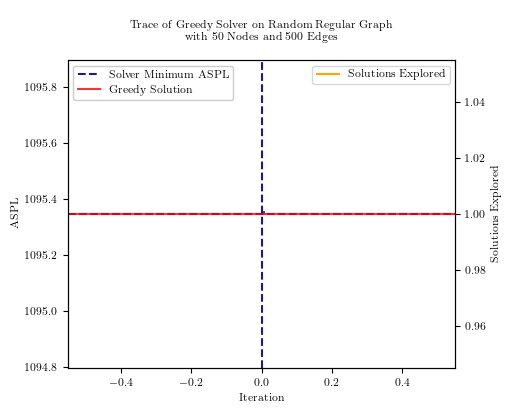

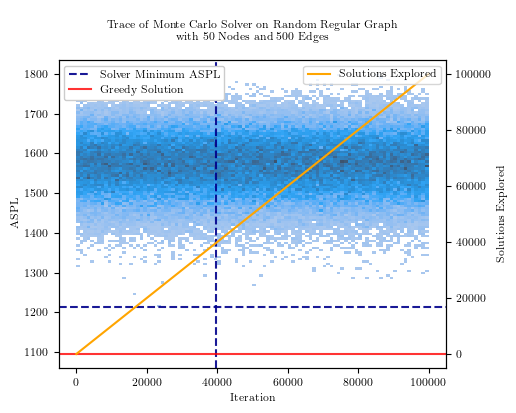

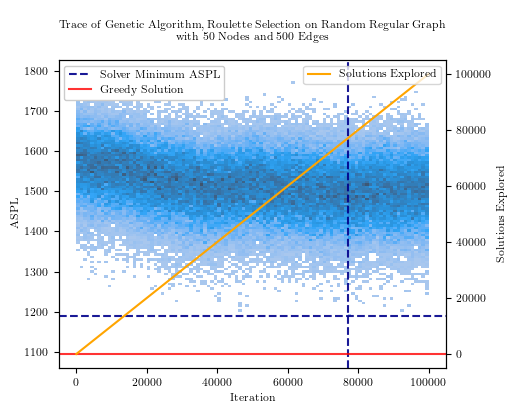

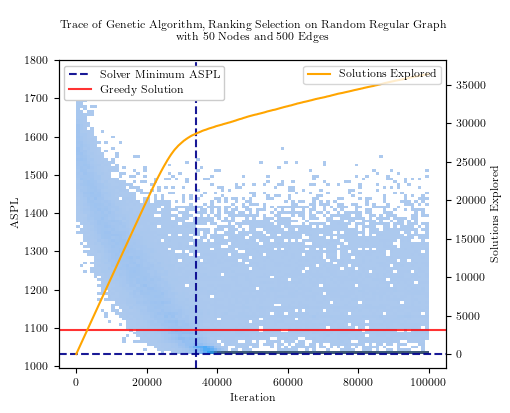

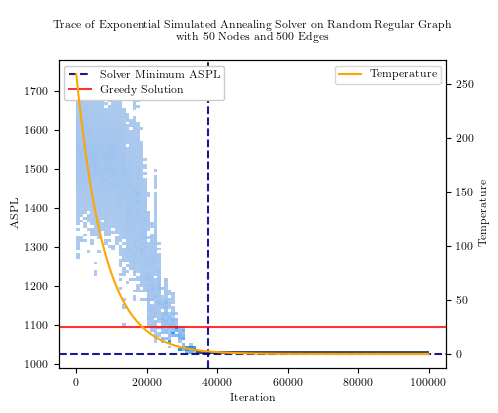

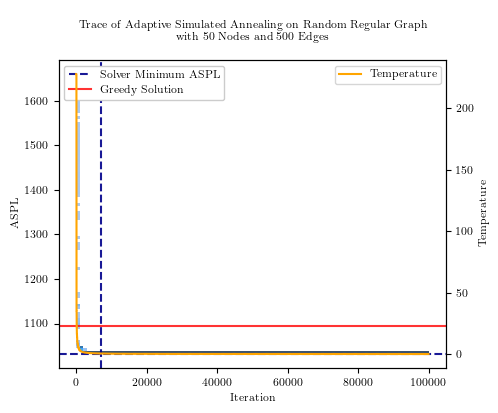

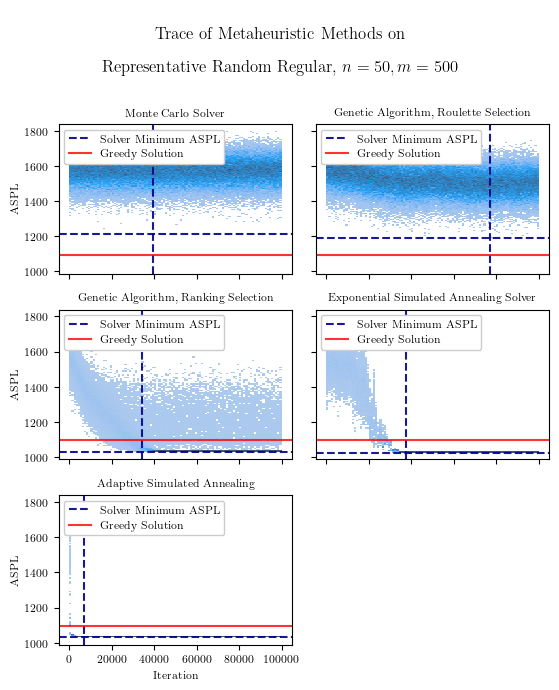

In [99]:
# Run trace
generate_traces(graph_generator, N, solvers, descriptions, 
    filename_prefix, trace_grid_filename, "Random Regular", caption_function,
    single_trace_figure_size, combined_trace_figure_size)

## Random Regular Graph, n = 50, sparse

Graph named 'RandomRegularGraph' with 50 nodes and 100 edges
{'generation_parameters': {'n': 50, 'd': 4}, 'class': 'RandomRegularGraph', 'density': 0.08163265306122448, 'name': 'RandomRegularGraph', 'weighter_class': 'Uniform Weighter', 'weighter': Uniform Weighter with parameters {'a': 1.0, 'b': 10000.0}}


Greedy Solver: 100%|██████████| 9/9 [00:00<00:00, 158.94it/s]

Solution generated by 'Greedy Solver' with 9 edges and ASPL 5074.165850263858
Reason for termination: iterations_exhausted

        Trace of Greedy Solver on Random Regular graph
with 50 Nodes and 100 Edges
         Trace of Greedy Solver - Ignore



Monte Carlo Solver: 100%|██████████| 100000/100000 [00:09<00:00, 10410.65it/s, best_aspl=6020.698811312241, aspl=7798.028172267784, solutions_explored=100000]


Solution generated by 'Monte Carlo Solver' with 9 edges and ASPL 6020.698811312241
Reason for termination: iterations_exhausted

        Trace of Monte Carlo Solver on Random Regular graph
with 50 Nodes and 100 Edges
         Trace of Monte-Carlo Search on a representative Random Regular graph with 99999 iterations.


Genetic Algorithm, Roulette Selection: 100%|██████████| 100/100 [00:13<00:00,  7.52it/s, best_aspl=5582.3735, aspl=7983.41, solutions_explored=99882] 


Solution generated by 'Genetic Algorithm, Roulette Selection' with 9 edges and ASPL 5582.37353515625
Reason for termination: iterations_exhausted

        Trace of Genetic Algorithm, Roulette Selection on Random Regular graph
with 50 Nodes and 100 Edges
         Trace of Genetic Algorithm on a representative Random Regular graph with 99 iterations, Roulette Selection.


Genetic Algorithm, Ranking Selection: 100%|██████████| 100/100 [00:12<00:00,  7.71it/s, best_aspl=4884.147, aspl=4884.147, solutions_explored=34909] 


Solution generated by 'Genetic Algorithm, Ranking Selection' with 9 edges and ASPL 4884.14697265625
Reason for termination: iterations_exhausted

        Trace of Genetic Algorithm, Ranking Selection on Random Regular graph
with 50 Nodes and 100 Edges
         Trace of Genetic Algorithm on a representative Random Regular graph with 99 iterations, Ranking Selection.


Exponential Simulated Annealing Solver: 100%|██████████| 100000/100000 [00:11<00:00, 9004.20it/s, best_aspl=4795.694424365939, aspl=4795.694424365939, solutions_explored=100000, temperature=0.0010001503221998575, log_acceptance_probability=-269807.51539347, delta=269.848073452722]   


Solution generated by 'Exponential Simulated Annealing Solver' with 9 edges and ASPL 4795.694424365939
Reason for termination: iterations_exhausted

        Trace of Exponential Simulated Annealing Solver on Random Regular graph
with 50 Nodes and 100 Edges
         Trace of Simulated Annealing Solver on a representative Random Regular graph, with 99999 iterations, using exponential cooling.


Adaptive Simulated Annealing: 100%|██████████| 100000/100000 [00:11<00:00, 9038.53it/s, best_aspl=4795.694424365938, aspl=4795.694424365938, solutions_explored=100000, temperature=0.00434436236935079, log_acceptance_probability=-72977.7701424759, delta=317.04187840610393]  


Solution generated by 'Adaptive Simulated Annealing' with 9 edges and ASPL 4795.694424365938
Reason for termination: iterations_exhausted

        Trace of Adaptive Simulated Annealing on Random Regular graph
with 50 Nodes and 100 Edges
         Trace of Simulated Annealing Solver on a representative Random Regular graph, with 99999 iterations, using adaptive cooling.


/var/folders/xm/ytd6ktbs0_n7mq72_0yz20pr0000gn/T/ipykernel_41125/3996097159.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


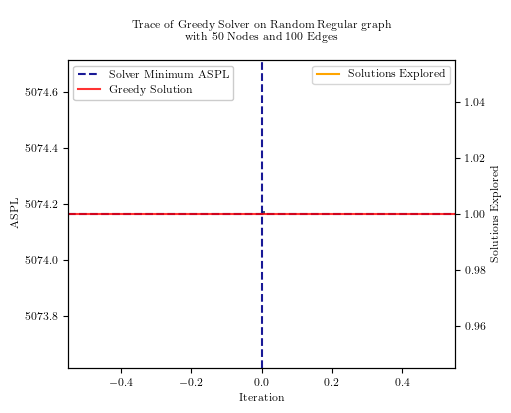

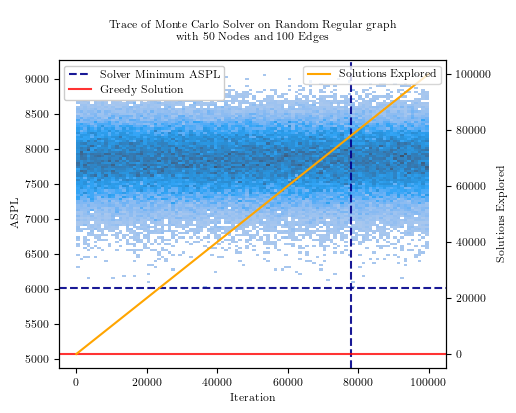

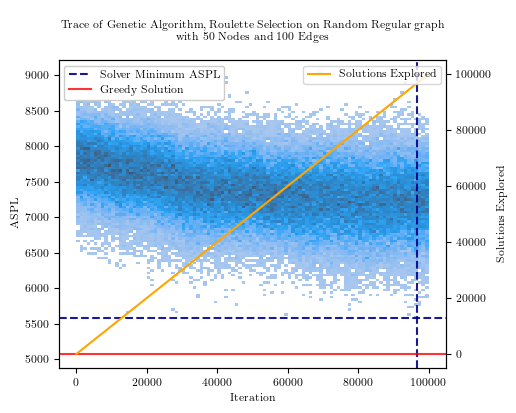

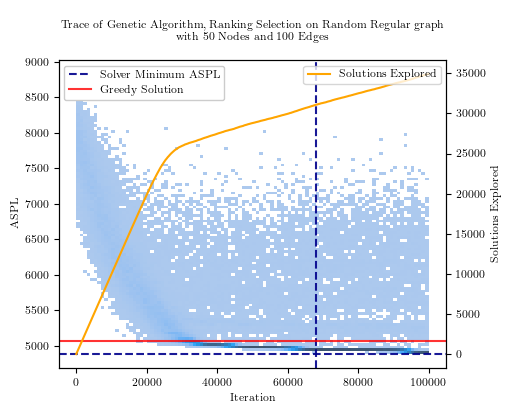

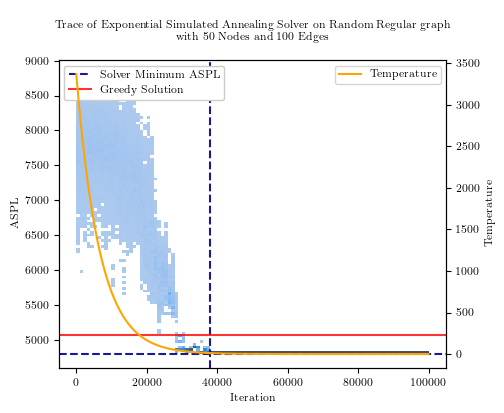

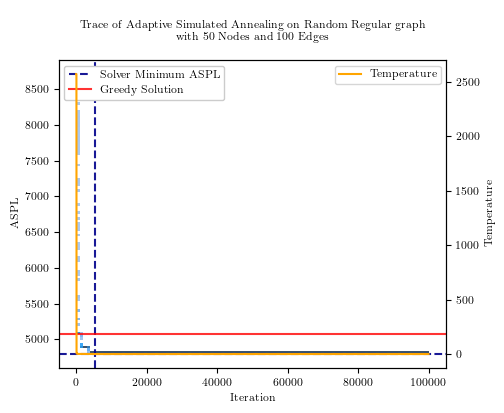

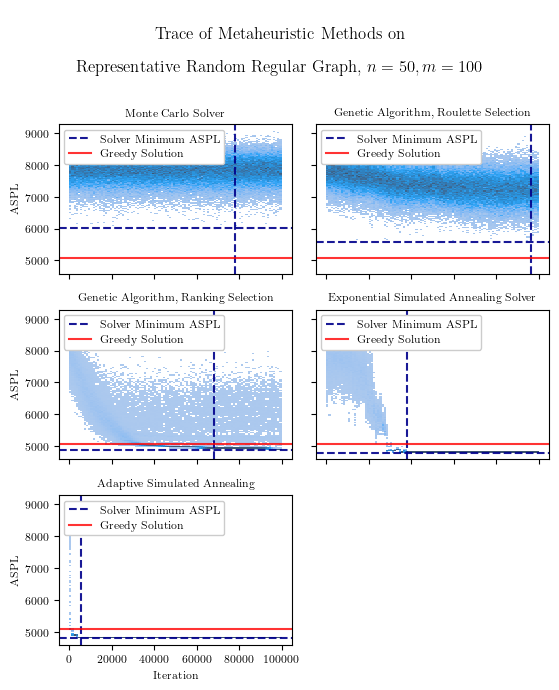

In [89]:
# Set Random Seeds

random.seed(42)
np.random.seed(42)

filename_prefix = "../dissertation/figures/trace4"
trace_grid_filename = '../dissertation/figures/sparse_small_random_trace.pdf'


maximum_time = 600
n = 50
graph_generator = RandomRegularGraph(n=n, d=4, weighter=weighter)
graph_name = 'Random Regular Graph'


# Run trace
generate_traces(graph_generator, N, solvers, descriptions, 
    filename_prefix, trace_grid_filename, graph_name, caption_function,
    single_trace_figure_size, combined_trace_figure_size)

## Random Regular Graph, 1000 Nodes

Graph named 'RandomRegularGraph' with 500 nodes and 25000 edges
{'generation_parameters': {'n': 500, 'd': 100}, 'class': 'RandomRegularGraph', 'density': 0.20040080160320642, 'name': 'RandomRegularGraph', 'weighter_class': 'Uniform Weighter', 'weighter': Uniform Weighter with parameters {'a': 1.0, 'b': 10000.0}}


Greedy Solver: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s]


Solution generated by 'Greedy Solver' with 9 edges and ASPL 656.0318598055833
Reason for termination: iterations_exhausted

        Trace of Greedy Solver on Random Regular graph
with 500 Nodes and 25000 Edges
         


Monte Carlo Solver: 100%|██████████| 20000/20000 [01:57<00:00, 170.02it/s, best_aspl=671.701957247437, aspl=694.8705362698565, solutions_explored=20000]


Solution generated by 'Monte Carlo Solver' with 9 edges and ASPL 671.701957247437
Reason for termination: iterations_exhausted

        Trace of Monte Carlo Solver on Random Regular graph
with 500 Nodes and 25000 Edges
         Trace of Monte-Carlo Search on a representative Random Regular graph with 19999 iterations.


Genetic Algoritm, Roulette Selection: 100%|██████████| 20/20 [01:55<00:00,  5.78s/it, best_aspl=676.3048, aspl=697.0151, solutions_explored=19980] 


Solution generated by 'Genetic Algoritm, Roulette Selection' with 9 edges and ASPL 676.3048095703125
Reason for termination: iterations_exhausted

        Trace of Genetic Algoritm, Roulette Selection on Random Regular graph
with 500 Nodes and 25000 Edges
         Trace of Genetic Algorithm on a representative Random Regular graph with 19 iterations, Roulette Selection.


Genetic Algoritm, Ranking Selection:  45%|████▌     | 9/20 [00:52<01:04,  5.86s/it, best_aspl=661.5076, aspl=685.1358, solutions_explored=9515]  


KeyboardInterrupt: 

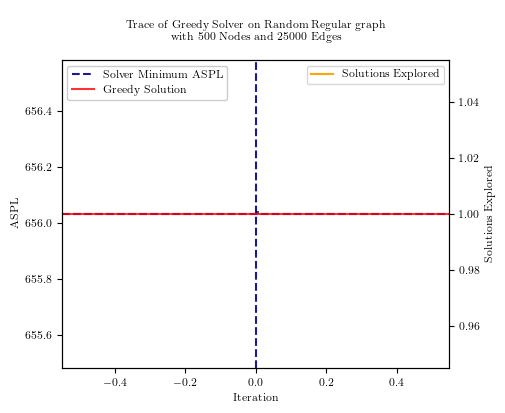

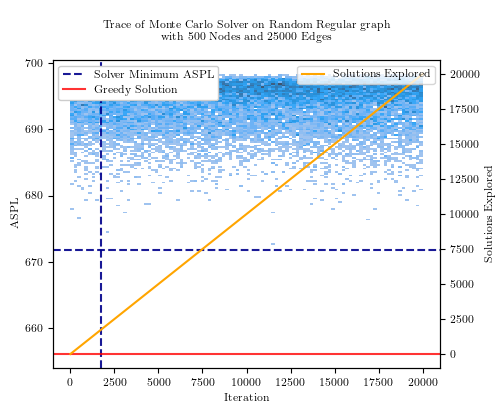

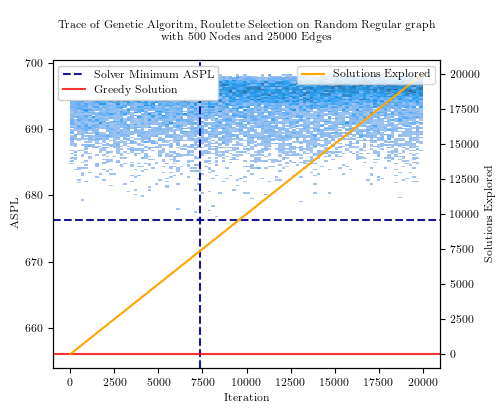

In [90]:
# Set Random Seeds

random.seed(42)
np.random.seed(42)

filename_prefix = "../dissertation/figures/trace3"
trace_grid_filename = '../dissertation/figures/dense_large_random_trace.pdf'

iterations = 20000
ga_iterations = iterations // ga_pool_size
maximum_time = 600
n = 500
graph_generator = RandomRegularGraph(n=n, d=100, weighter=weighter)
graph_name = 'Random Regular Graph'

solvers = [
    GreedySolver(),
    MonteCarloSolver(maximum_time=maximum_time, maximum_iterations=iterations, early_stopping=False),
    GeneticSolver(early_stopping=early_stopping, method_name="Genetic Algorithm, Roulette Selection", patience=50000, population_size=1000, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="roulette", maximum_iterations=ga_iterations, trace_probabilities=True),
    GeneticSolver(early_stopping=early_stopping, method_name="Genetic Algorithm, Ranking Selection", patience=50000, population_size=ga_pool_size, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="ranking", maximum_iterations=ga_iterations),
    SimulatedAnnealingSolver(early_stopping=early_stopping, method_name = 'Exponential Simulated Annealing Solver', patience=50000,  maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', annealing_schedule="exponential", initial_temperature=None, minimum_temperature=0.001),
    SimulatedAnnealingSolver(early_stopping=early_stopping, method_name = 'Adaptive Simulated Annealing', patience=50000, maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', acceptance_window=50, annealing_schedule="adaptive", initial_temperature=None, minimum_temperature=0.001),
]

descriptions = [
    "",
    "Trace of Monte-Carlo Search on a representative Random Regular graph with {solution.iterations} iterations.",
    "Trace of Genetic Algorithm on a representative Random Regular graph with {solution.iterations} iterations, Roulette Selection.",
    "Trace of Genetic Algorithm on a representative Random Regular graph with {solution.iterations} iterations, Ranking Selection.",
    "Trace of Simulated Annealing Solver on a representative Random Regular graph, with {solution.iterations} iterations, using exponential cooling.",
    "Trace of Simulated Annealing Solver on a representative Random Regular graph, with {solution.iterations} iterations, using adaptive cooling.",

]

# Run trace
generate_traces(graph_generator, N, solvers, descriptions, 
    filename_prefix, trace_grid_filename, graph_name, caption_function,
    single_trace_figure_size, combined_trace_figure_size)

## Watts Strogatz, 50 Nodes,Sparse

Graph named 'WattsStrogatzGraph' with 50 nodes and 100 edges
{'generation_parameters': {'n': 50, 'k': 5, 'p': 0.5}, 'class': 'WattsStrogatzGraph', 'density': 0.08163265306122448, 'name': 'WattsStrogatzGraph', 'weighter_class': 'Uniform Weighter', 'weighter': Uniform Weighter with parameters {'a': 1.0, 'b': 10000.0}}


Greedy Solver: 100%|██████████| 9/9 [00:00<00:00, 416.53it/s]

Solution generated by 'Greedy Solver' with 9 edges and ASPL 5816.179913966938
Reason for termination: iterations_exhausted

        Trace of Greedy Solver on Random Regular graph
with 50 Nodes and 100 Edges
         



Monte Carlo Solver: 100%|██████████| 100000/100000 [00:09<00:00, 10962.06it/s, best_aspl=6454.263968761897, aspl=7962.941592228285, solutions_explored=100000]


Solution generated by 'Monte Carlo Solver' with 9 edges and ASPL 6454.263968761897
Reason for termination: iterations_exhausted

        Trace of Monte Carlo Solver on Random Regular graph
with 50 Nodes and 100 Edges
         Trace of Monte-Carlo Search on a Watts-Strogatz graph with 99999 iterations.


Genetic Algorithm, Roulette Selection: 100%|██████████| 100/100 [00:12<00:00,  7.92it/s, best_aspl=5963.3555, aspl=7541.9263, solutions_explored=99890]


Solution generated by 'Genetic Algorithm, Roulette Selection' with 9 edges and ASPL 5963.35546875
Reason for termination: iterations_exhausted

        Trace of Genetic Algorithm, Roulette Selection on Random Regular graph
with 50 Nodes and 100 Edges
         Trace of Genetic Algorithm on a Watts-Strogatz graph with 99 iterations, Roulette Selection.


Genetic Algorithm, Ranking Selection: 100%|██████████| 100/100 [00:12<00:00,  8.08it/s, best_aspl=5133.769, aspl=5133.769, solutions_explored=34757] 


Solution generated by 'Genetic Algorithm, Ranking Selection' with 9 edges and ASPL 5133.76904296875
Reason for termination: iterations_exhausted

        Trace of Genetic Algorithm, Ranking Selection on Random Regular graph
with 50 Nodes and 100 Edges
         Trace of Genetic Algorithm on a Watts-Strogatz graph with 99 iterations, Ranking Selection.


Exponential Simulated Annealing Solver: 100%|██████████| 100000/100000 [00:10<00:00, 9867.92it/s, best_aspl=5107.532064437877, aspl=5107.532064437877, solutions_explored=100000, temperature=0.00100014763510884, log_acceptance_probability=-297916.8070616456, delta=297.9607900418814]   


Solution generated by 'Exponential Simulated Annealing Solver' with 9 edges and ASPL 5107.532064437877
Reason for termination: iterations_exhausted

        Trace of Exponential Simulated Annealing Solver on Random Regular graph
with 50 Nodes and 100 Edges
         Trace of Simulated Annealing Solver on a Watts-Strogatz graph, with 99999 iterations, using exponential cooling.


Adaptive Simulated Annealing: 100%|██████████| 100000/100000 [00:10<00:00, 9892.39it/s, best_aspl=5107.532064437878, aspl=5107.532064437878, solutions_explored=100000, temperature=0.004627795984739231, log_acceptance_probability=-238360.57652509733, delta=1103.0841189629737]


Solution generated by 'Adaptive Simulated Annealing' with 9 edges and ASPL 5107.532064437878
Reason for termination: iterations_exhausted

        Trace of Adaptive Simulated Annealing on Random Regular graph
with 50 Nodes and 100 Edges
         Trace of Simulated Annealing Solver on a Watts-Strogatz graph, with 99999 iterations, using adaptive cooling.


/var/folders/xm/ytd6ktbs0_n7mq72_0yz20pr0000gn/T/ipykernel_41125/3996097159.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


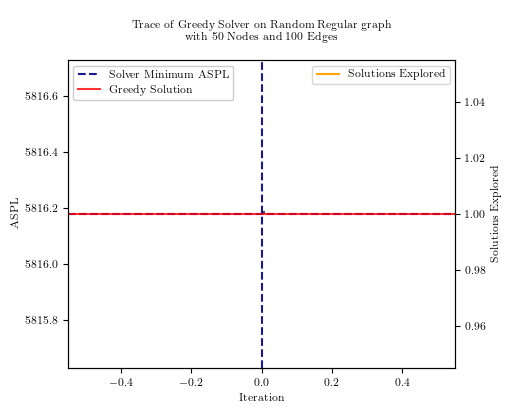

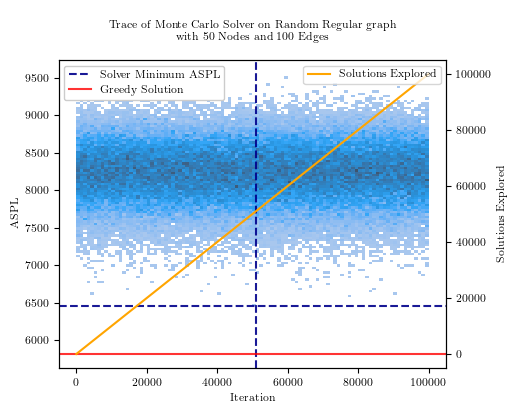

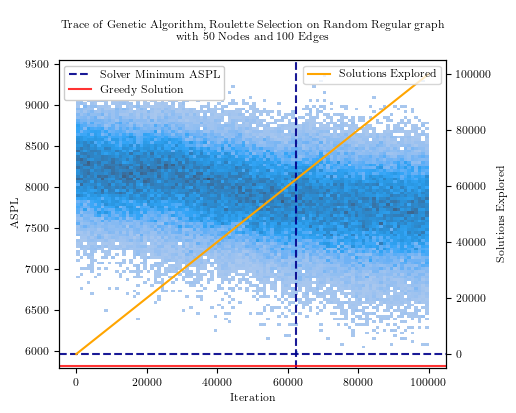

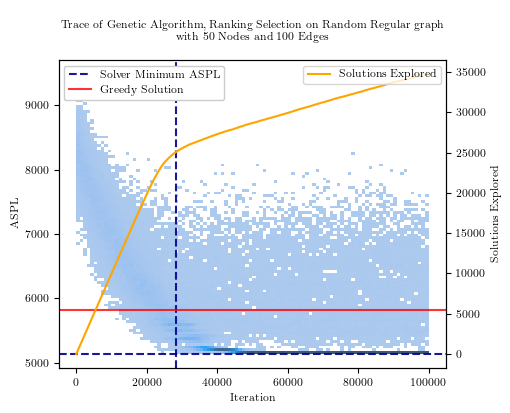

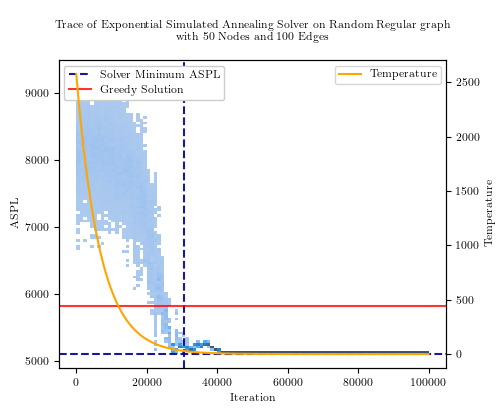

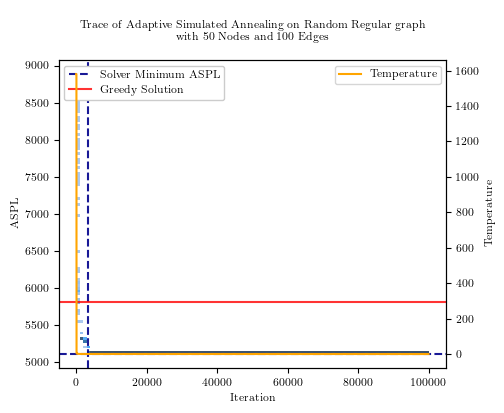

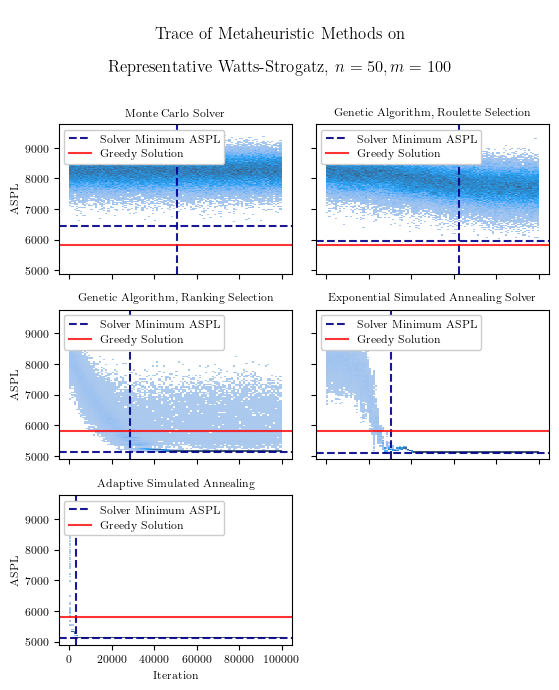

In [91]:
# Set Random Seeds

random.seed(42)
np.random.seed(42)

filename_prefix = "../dissertation/figures/trace5"
trace_grid_filename = '../dissertation/figures/dense_large_random_trace.pdf'


iterations = 100000
ga_iterations = iterations // ga_pool_size
maximum_time = 600
n = 50
graph_generator = WattsStrogatzGraph(n=n, k=5, p=0.5, weighter=weighter)
graph_name = 'Watts-Strogatz'

solvers = [
    GreedySolver(),
    MonteCarloSolver(maximum_time=maximum_time, maximum_iterations=iterations, early_stopping=False),
    GeneticSolver(early_stopping=early_stopping, method_name="Genetic Algorithm, Roulette Selection", patience=50000, population_size=1000, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="roulette", maximum_iterations=ga_iterations, trace_probabilities=True),
    GeneticSolver(early_stopping=early_stopping, method_name="Genetic Algorithm, Ranking Selection", patience=50000, population_size=ga_pool_size, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="ranking", maximum_iterations=ga_iterations),
    SimulatedAnnealingSolver(early_stopping=early_stopping, method_name = 'Exponential Simulated Annealing Solver', patience=50000,  maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', annealing_schedule="exponential", initial_temperature=None, minimum_temperature=0.001),
    SimulatedAnnealingSolver(early_stopping=early_stopping, method_name = 'Adaptive Simulated Annealing', patience=50000, maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', acceptance_window=50, annealing_schedule="adaptive", initial_temperature=None, minimum_temperature=0.001),
]

descriptions = [
    "",
    "Trace of Monte-Carlo Search on a Watts-Strogatz graph with {solution.iterations} iterations.",
    "Trace of Genetic Algorithm on a Watts-Strogatz graph with {solution.iterations} iterations, Roulette Selection.",
    "Trace of Genetic Algorithm on a Watts-Strogatz graph with {solution.iterations} iterations, Ranking Selection.",
    "Trace of Simulated Annealing Solver on a Watts-Strogatz graph, with {solution.iterations} iterations, using exponential cooling.",
    "Trace of Simulated Annealing Solver on a Watts-Strogatz graph, with {solution.iterations} iterations, using adaptive cooling.",

]

# Run trace
generate_traces(graph_generator, N, solvers, descriptions, 
    filename_prefix, trace_grid_filename, graph_name, caption_function,
    single_trace_figure_size, combined_trace_figure_size)

## Watts Strogatz, 50 Nodes,Sparse

In [ ]:
# Set Random Seeds

random.seed(42)
np.random.seed(42)

filename_prefix = "../dissertation/figures/trace5"
trace_grid_filename = '../dissertation/figures/dense_large_random_trace.pdf'


iterations = 100000
ga_iterations = iterations // ga_pool_size
maximum_time = 600
n = 50
graph_generator = WattsStrogatzGraph(n=n, k=5, p=0.5, weighter=weighter)
graph_name = 'Watts-Strogatz'

solvers = [
    GreedySolver(),
    MonteCarloSolver(maximum_time=maximum_time, maximum_iterations=iterations, early_stopping=False),
    GeneticSolver(early_stopping=early_stopping, method_name="Genetic Algorithm, Roulette Selection", patience=50000, population_size=1000, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="roulette", maximum_iterations=ga_iterations, trace_probabilities=True),
    GeneticSolver(early_stopping=early_stopping, method_name="Genetic Algorithm, Ranking Selection", patience=50000, population_size=ga_pool_size, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="ranking", maximum_iterations=ga_iterations),
    SimulatedAnnealingSolver(early_stopping=early_stopping, method_name = 'Exponential Simulated Annealing Solver', patience=50000,  maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', annealing_schedule="exponential", initial_temperature=None, minimum_temperature=0.001),
    SimulatedAnnealingSolver(early_stopping=early_stopping, method_name = 'Adaptive Simulated Annealing', patience=50000, maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', acceptance_window=50, annealing_schedule="adaptive", initial_temperature=None, minimum_temperature=0.001),
]

descriptions = [
    "",
    "Trace of Monte-Carlo Search on a Watts-Strogatz graph with {solution.iterations} iterations.",
    "Trace of Genetic Algorithm on a Watts-Strogatz graph with {solution.iterations} iterations, Roulette Selection.",
    "Trace of Genetic Algorithm on a Watts-Strogatz graph with {solution.iterations} iterations, Ranking Selection.",
    "Trace of Simulated Annealing Solver on a Watts-Strogatz graph, with {solution.iterations} iterations, using exponential cooling.",
    "Trace of Simulated Annealing Solver on a Watts-Strogatz graph, with {solution.iterations} iterations, using adaptive cooling.",

]

# Run trace
generate_traces(graph_generator, N, solvers, descriptions, 
    filename_prefix, trace_grid_filename, graph_name, caption_function,
    single_trace_figure_size, combined_trace_figure_size)

Graph named 'WattsStrogatzGraph' with 50 nodes and 100 edges
{'generation_parameters': {'n': 50, 'k': 5, 'p': 0.5}, 'class': 'WattsStrogatzGraph', 'density': 0.08163265306122448, 'name': 'WattsStrogatzGraph', 'weighter_class': 'Uniform Weighter', 'weighter': Uniform Weighter with parameters {'a': 1.0, 'b': 10000.0}}


Greedy Solver: 100%|██████████| 9/9 [00:00<00:00, 416.53it/s]

Solution generated by 'Greedy Solver' with 9 edges and ASPL 5816.179913966938
Reason for termination: iterations_exhausted

        Trace of Greedy Solver on Random Regular graph
with 50 Nodes and 100 Edges
         



Monte Carlo Solver: 100%|██████████| 100000/100000 [00:09<00:00, 10962.06it/s, best_aspl=6454.263968761897, aspl=7962.941592228285, solutions_explored=100000]


Solution generated by 'Monte Carlo Solver' with 9 edges and ASPL 6454.263968761897
Reason for termination: iterations_exhausted

        Trace of Monte Carlo Solver on Random Regular graph
with 50 Nodes and 100 Edges
         Trace of Monte-Carlo Search on a Watts-Strogatz graph with 99999 iterations.


Genetic Algorithm, Roulette Selection: 100%|██████████| 100/100 [00:12<00:00,  7.92it/s, best_aspl=5963.3555, aspl=7541.9263, solutions_explored=99890]


Solution generated by 'Genetic Algorithm, Roulette Selection' with 9 edges and ASPL 5963.35546875
Reason for termination: iterations_exhausted

        Trace of Genetic Algorithm, Roulette Selection on Random Regular graph
with 50 Nodes and 100 Edges
         Trace of Genetic Algorithm on a Watts-Strogatz graph with 99 iterations, Roulette Selection.


Genetic Algorithm, Ranking Selection: 100%|██████████| 100/100 [00:12<00:00,  8.08it/s, best_aspl=5133.769, aspl=5133.769, solutions_explored=34757] 


## Watts Strogatz, 50 Nodes,Dense

Graph named 'WattsStrogatzGraph' with 50 nodes and 1000 edges
{'generation_parameters': {'n': 50, 'k': 40, 'p': 0.5}, 'class': 'WattsStrogatzGraph', 'density': 0.8163265306122449, 'name': 'WattsStrogatzGraph', 'weighter_class': 'Uniform Weighter', 'weighter': Uniform Weighter with parameters {'a': 1.0, 'b': 10000.0}}


Greedy Solver: 100%|██████████| 9/9 [00:00<00:00, 405.20it/s]

Solution generated by 'Greedy Solver' with 9 edges and ASPL 687.9592522625418
Reason for termination: iterations_exhausted

        Trace of Greedy Solver on Random Regular graph
with 50 Nodes and 1000 Edges
         



Monte Carlo Solver: 100%|██████████| 100000/100000 [00:09<00:00, 11065.03it/s, best_aspl=783.3948901887389, aspl=876.8237956118861, solutions_explored=100000]


Solution generated by 'Monte Carlo Solver' with 9 edges and ASPL 783.3948901887389
Reason for termination: iterations_exhausted

        Trace of Monte Carlo Solver on Random Regular graph
with 50 Nodes and 1000 Edges
         Trace of Monte-Carlo Search on a Watts-Strogatz graph with 99999 iterations.


Genetic Algorithm, Roulette Selection: 100%|██████████| 100/100 [00:12<00:00,  8.21it/s, best_aspl=762.0454, aspl=877.88806, solutions_explored=99885]


Solution generated by 'Genetic Algorithm, Roulette Selection' with 9 edges and ASPL 762.04541015625
Reason for termination: iterations_exhausted

        Trace of Genetic Algorithm, Roulette Selection on Random Regular graph
with 50 Nodes and 1000 Edges
         Trace of Genetic Algorithm on a Watts-Strogatz graph with 99 iterations, Roulette Selection.


Genetic Algorithm, Ranking Selection: 100%|██████████| 100/100 [00:11<00:00,  8.38it/s, best_aspl=670.3985, aspl=671.7179, solutions_explored=32757] 


Solution generated by 'Genetic Algorithm, Ranking Selection' with 9 edges and ASPL 670.3984985351562
Reason for termination: iterations_exhausted

        Trace of Genetic Algorithm, Ranking Selection on Random Regular graph
with 50 Nodes and 1000 Edges
         Trace of Genetic Algorithm on a Watts-Strogatz graph with 99 iterations, Ranking Selection.


Exponential Simulated Annealing Solver: 100%|█████████▉| 99999/100000 [00:09<00:00, 10090.92it/s, best_aspl=669.6016773293251, aspl=669.6016773293251, solutions_explored=100000, temperature=0.0010001209916061884, log_acceptance_probability=-29148.07489772761, delta=29.151601570126786]


Solution generated by 'Exponential Simulated Annealing Solver' with 9 edges and ASPL 669.6016773293251
Reason for termination: minimum_temperature

        Trace of Exponential Simulated Annealing Solver on Random Regular graph
with 50 Nodes and 1000 Edges
         Trace of Simulated Annealing Solver on a Watts-Strogatz graph, with 99999 iterations, using exponential cooling.


Adaptive Simulated Annealing: 100%|██████████| 100000/100000 [00:09<00:00, 10226.60it/s, best_aspl=673.1610245511961, aspl=673.1610245511961, solutions_explored=100000, temperature=0.10049707944289153, log_acceptance_probability=-433.7127947794568, delta=43.58686919234958]  


Solution generated by 'Adaptive Simulated Annealing' with 9 edges and ASPL 673.1610245511961
Reason for termination: iterations_exhausted

        Trace of Adaptive Simulated Annealing on Random Regular graph
with 50 Nodes and 1000 Edges
         Trace of Simulated Annealing Solver on a Watts-Strogatz graph, with 99999 iterations, using adaptive cooling.


/var/folders/xm/ytd6ktbs0_n7mq72_0yz20pr0000gn/T/ipykernel_41125/3996097159.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


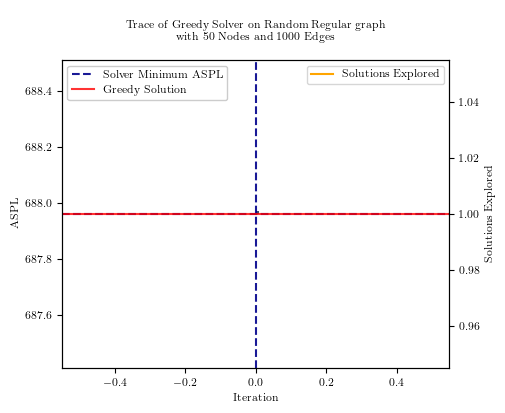

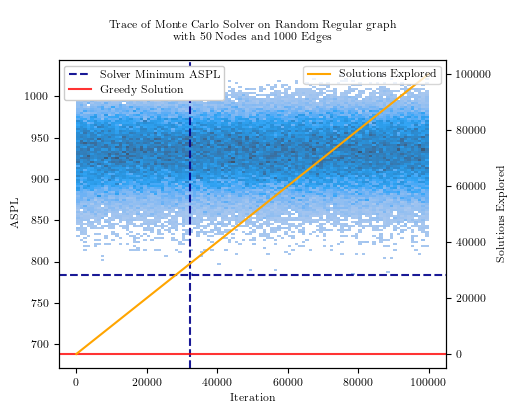

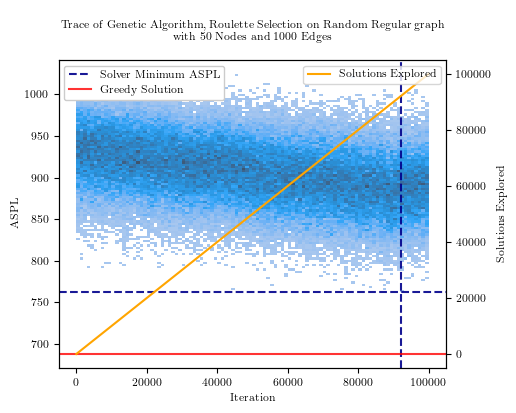

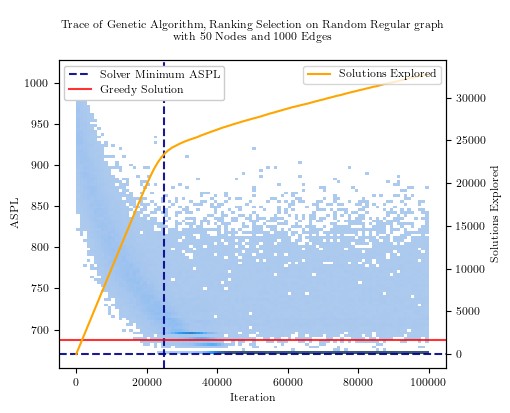

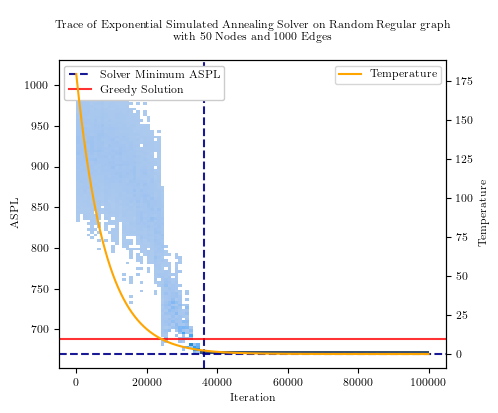

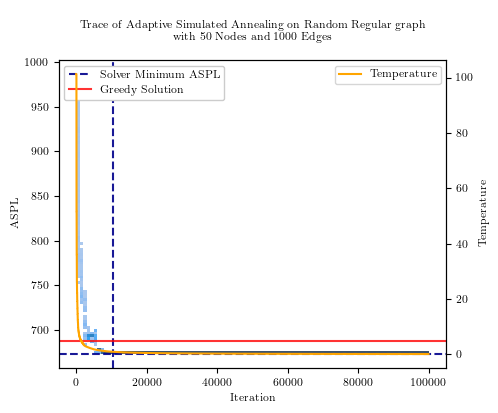

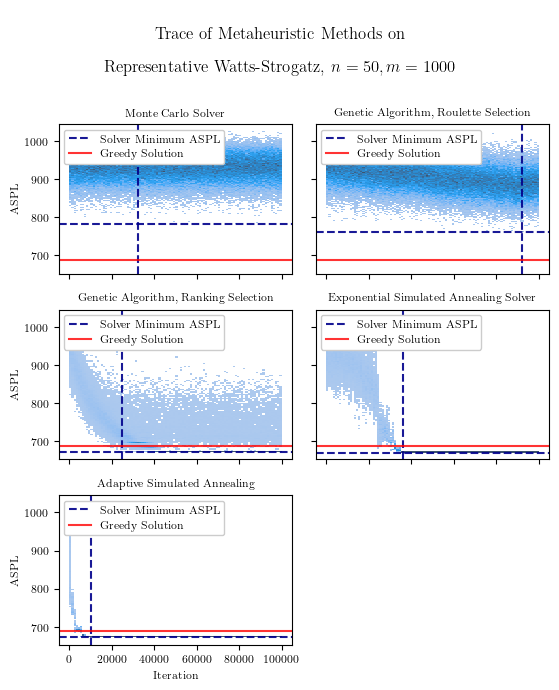

In [94]:
# Set Random Seeds

random.seed(42)
np.random.seed(42)

filename_prefix = "../dissertation/figures/trace6"
trace_grid_filename = '../dissertation/figures/dense_small_ws_trace.pdf'


iterations = 100000
ga_iterations = iterations // ga_pool_size
maximum_time = 600
n = 50
graph_generator = WattsStrogatzGraph(n=n, k=40, p=0.5, weighter=weighter)
graph_name = 'Watts-Strogatz'

solvers = [
    GreedySolver(),
    MonteCarloSolver(maximum_time=maximum_time, maximum_iterations=iterations, early_stopping=False),
    GeneticSolver(early_stopping=early_stopping, method_name="Genetic Algorithm, Roulette Selection", patience=50000, population_size=1000, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="roulette", maximum_iterations=ga_iterations, trace_probabilities=True),
    GeneticSolver(early_stopping=early_stopping, method_name="Genetic Algorithm, Ranking Selection", patience=50000, population_size=ga_pool_size, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="ranking", maximum_iterations=ga_iterations),
    SimulatedAnnealingSolver(early_stopping=early_stopping, method_name = 'Exponential Simulated Annealing Solver', patience=50000,  maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', annealing_schedule="exponential", initial_temperature=None, minimum_temperature=0.001),
    SimulatedAnnealingSolver(early_stopping=early_stopping, method_name = 'Adaptive Simulated Annealing', patience=50000, maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', acceptance_window=50, annealing_schedule="adaptive", initial_temperature=None, minimum_temperature=0.001),
]

descriptions = [
    "",
    "Trace of Monte-Carlo Search on a Watts-Strogatz graph with {solution.iterations} iterations.",
    "Trace of Genetic Algorithm on a Watts-Strogatz graph with {solution.iterations} iterations, Roulette Selection.",
    "Trace of Genetic Algorithm on a Watts-Strogatz graph with {solution.iterations} iterations, Ranking Selection.",
    "Trace of Simulated Annealing Solver on a Watts-Strogatz graph, with {solution.iterations} iterations, using exponential cooling.",
    "Trace of Simulated Annealing Solver on a Watts-Strogatz graph, with {solution.iterations} iterations, using adaptive cooling.",

]

# Run trace
generate_traces(graph_generator, N, solvers, descriptions, 
    filename_prefix, trace_grid_filename, graph_name, caption_function,
    single_trace_figure_size, combined_trace_figure_size)

## Watts Strogatz, 500 Nodes, Sparse

Graph named 'WattsStrogatzGraph' with 500 nodes and 500 edges
{'generation_parameters': {'n': 500, 'k': 3, 'p': 0.5}, 'class': 'WattsStrogatzGraph', 'density': 0.004008016032064128, 'name': 'WattsStrogatzGraph', 'weighter_class': 'Uniform Weighter', 'weighter': Uniform Weighter with parameters {'a': 1.0, 'b': 10000.0}}


Greedy Solver:  33%|███▎      | 3/9 [00:00<00:00,  6.95it/s]

Greedy Solver: 100%|██████████| 9/9 [00:01<00:00,  7.13it/s]


Solution generated by 'Greedy Solver' with 9 edges and ASPL 67209.23048419716
Reason for termination: iterations_exhausted

        Trace of Greedy Solver on Random Regular graph
with 500 Nodes and 500 Edges
         


Monte Carlo Solver: 100%|██████████| 20000/20000 [02:02<00:00, 163.88it/s, best_aspl=81006.02546958694, aspl=97623.58143967042, solutions_explored=20000] 


Solution generated by 'Monte Carlo Solver' with 9 edges and ASPL 81006.02546958694
Reason for termination: iterations_exhausted

        Trace of Monte Carlo Solver on Random Regular graph
with 500 Nodes and 500 Edges
         Trace of Monte-Carlo Search on a Watts-Strogatz graph with 19999 iterations.


Genetic Algorithm, Roulette Selection: 100%|██████████| 20/20 [02:00<00:00,  6.04s/it, best_aspl=79725.57, aspl=101212.305, solutions_explored=19983]


Solution generated by 'Genetic Algorithm, Roulette Selection' with 9 edges and ASPL 79725.5703125
Reason for termination: iterations_exhausted

        Trace of Genetic Algorithm, Roulette Selection on Random Regular graph
with 500 Nodes and 500 Edges
         Trace of Genetic Algorithm on a Watts-Strogatz graph with 19 iterations, Roulette Selection.


Genetic Algorithm, Ranking Selection:  20%|██        | 4/20 [00:26<01:47,  6.74s/it, best_aspl=79916.51, aspl=95974.89, solutions_explored=4427]  


KeyboardInterrupt: 

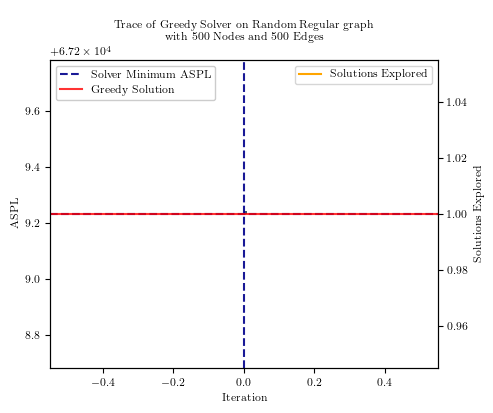

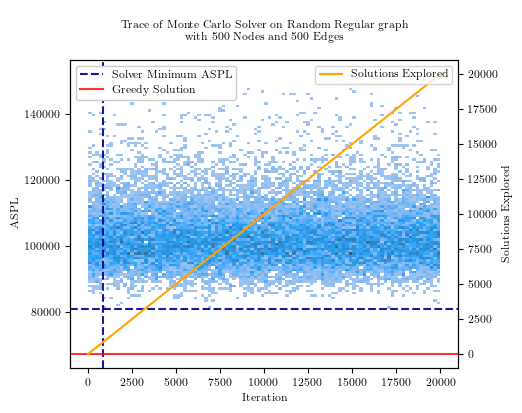

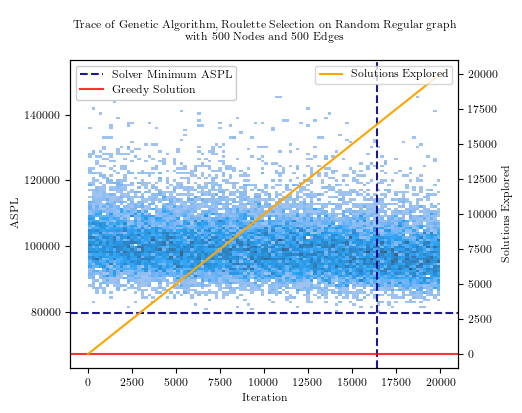

In [96]:
# Set Random Seeds

random.seed(42)
np.random.seed(42)

filename_prefix = "../dissertation/figures/trace7"
trace_grid_filename = '../dissertation/figures/sparse_500_ws_trace.pdf'

iterations = 20000
ga_iterations = iterations // ga_pool_size
maximum_time = 600
n = 500
graph_generator = WattsStrogatzGraph(n=n, k=3, p=0.5, weighter=weighter)
graph_name = 'Watts-Strogatz'

solvers = [
    GreedySolver(),
    MonteCarloSolver(maximum_time=maximum_time, maximum_iterations=iterations, early_stopping=False),
    GeneticSolver(early_stopping=early_stopping, method_name="Genetic Algorithm, Roulette Selection", patience=50000, population_size=1000, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="roulette", maximum_iterations=ga_iterations, trace_probabilities=True),
    GeneticSolver(early_stopping=early_stopping, method_name="Genetic Algorithm, Ranking Selection", patience=50000, population_size=ga_pool_size, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="ranking", maximum_iterations=ga_iterations),
    SimulatedAnnealingSolver(early_stopping=early_stopping, method_name = 'Exponential Simulated Annealing Solver', patience=50000,  maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', annealing_schedule="exponential", initial_temperature=None, minimum_temperature=0.001),
    SimulatedAnnealingSolver(early_stopping=early_stopping, method_name = 'Adaptive Simulated Annealing', patience=50000, maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', acceptance_window=50, annealing_schedule="adaptive", initial_temperature=None, minimum_temperature=0.001),
]

descriptions = [
    "",
    "Trace of Monte-Carlo Search on a Watts-Strogatz graph with {solution.iterations} iterations.",
    "Trace of Genetic Algorithm on a Watts-Strogatz graph with {solution.iterations} iterations, Roulette Selection.",
    "Trace of Genetic Algorithm on a Watts-Strogatz graph with {solution.iterations} iterations, Ranking Selection.",
    "Trace of Simulated Annealing Solver on a Watts-Strogatz graph, with {solution.iterations} iterations, using exponential cooling.",
    "Trace of Simulated Annealing Solver on a Watts-Strogatz graph, with {solution.iterations} iterations, using adaptive cooling.",

]

# Run trace
generate_traces(graph_generator, N, solvers, descriptions, 
    filename_prefix, trace_grid_filename, graph_name, caption_function,
    single_trace_figure_size, combined_trace_figure_size)

## GA Roulette Selection Plot
For the roulette selection GA, plot the trace of its probabilities.

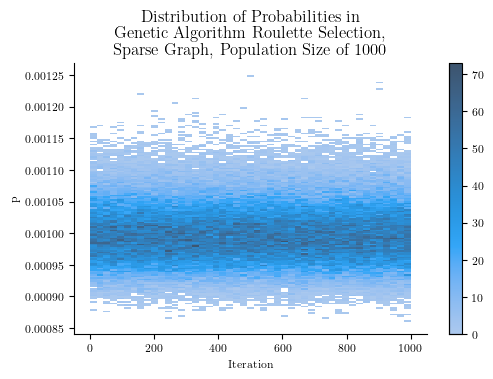

In [88]:
# From the last problem run, find a GA that used roulette selection
# and plot it.
for solution in problem.solutions:
    if solution.parameters.get('selection_method') == 'roulette':
        # Get the probability trace for the solution.
        # This is stored as a paramter in the solution object,
        # rather than a trace.
        p = solution.parameters['probability_trace']
        df = pd.DataFrame(p)
        df = df.transpose()
        df['iteration'] = df.index
        df = pd.melt(df, id_vars=['iteration'], var_name='creature', value_name='p')
        break


xdim, ydim = visualisation.calculate_size()
fig, ax = plt.subplots(figsize=(xdim,ydim))
g = sns.histplot(data=df, x='iteration', y='p', cbar=True, ax=ax)
g.set(title="Distribution of Probabilities in\nGenetic Algorithm Roulette Selection,\nSparse Graph, Population Size of 1000",
    xlabel="Iteration")
sns.despine()
visualisation.save_plot(fig, "../dissertation/figures/roulette_p_sparse.pdf")
        

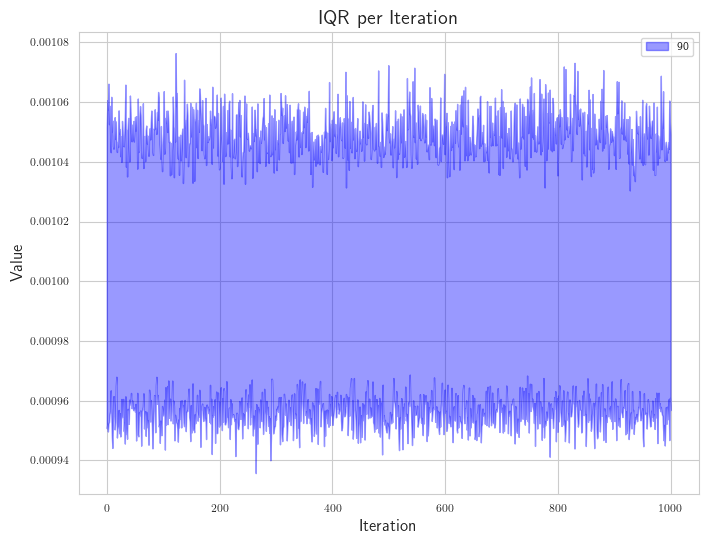

In [101]:
percentiles = df.groupby('iteration')['p'].quantile([0.05, 0.5, 0.95]).unstack()

# Set the style for the plot
sns.set_style('whitegrid')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))


# Plot the 50th percentile (median) line
#ax.plot(percentiles.index, percentiles[0.5], color='blue', label='Median')

# Fill the area between the 25th and 75th percentiles
ax.fill_between(percentiles.index, percentiles[0.05], percentiles[0.95],
                color='blue', alpha=0.4, label='90% Interval')

# Set the plot title and labels
ax.set_title('IQR per Iteration')
ax.set_xlabel('Iteration')
ax.set_ylabel('Value')

# Add a legend
ax.legend()

plt.show()

<Axes: xlabel='p', ylabel='Density'>

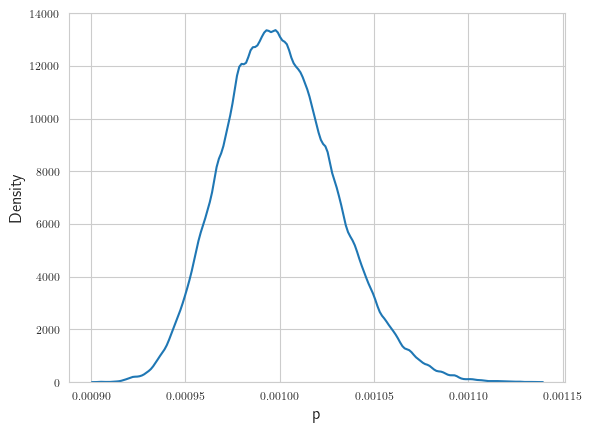

In [106]:
sns.kdeplot(df['p'], bw_adjust=0.5)